##  Stochastic RNA velocity analysis of dentate gyrus using scvelo

The dataset used in here for velocity analysis is from the dentate gyrus, a part of the hippocampus which is involved in learning, episodic memory formation and spatial coding. <br>
It is measured using 10X Genomics Chromium and described in Hochgerner et al. (2018). The data consists of 25,919 genes across 3,396 cells and provides several interesting characteristics. 

We use a stochastic version of the model for transcriptional dynamics used in velocyto (developed by the Linnarsson lab and Kharchenko Lab).

RNA velocity reference https://www.nature.com/articles/s41586-018-0414-6 <br>
This notebook is based on http://pklab.med.harvard.edu/velocyto/notebooks/R/DG1.nb.html

Files needed: 10X43_1.loom (will be downloaded automatically) <br> 
Optional files: DG_umap.npy, DG_clusters.npy

In [1]:
from os import path
import numpy as np
import matplotlib.pyplot as pl

import scvelo as scv
import scanpy.api as sc
sc.settings.verbosity=3 # i.e. show errors(0), warnings(1), infos(2) and hints(3)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

results_file = './write/DentateGyrus.h5ad' 
scv.logging.print_version_and_date()

Running scvelo 0.1.2+5.g6d56fdd on 2018-08-21 23:06.


## Load and cleanup the data

In [2]:
adata = sc.read("data/DentateGyrus/10X43_1.loom", cleanup=True, sparse=True, cache=True, 
                backup_url="http://pklab.med.harvard.edu/velocyto/DG1/10X43_1.loom")

... reading from cache file ./cache/data-DentateGyrus-10X43_1.h5ad


In [3]:
sc.logging.print_memory_usage()
scv.pp.print_fraction_of_abundances(adata, cleanup_layers=True)

adata

Memory usage: current 0.34 GB, difference +0.34 GB
abundance of ['spliced', 'unspliced', 'ambiguous']: [0.68 0.08 0.24]


AnnData object with n_obs × n_vars = 3396 × 25919 
    obs: '_KMeans_10', 'cr_PC1', 'cr_PC2', 'cr_tSNE1', 'cr_tSNE2'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'spliced', 'unspliced'

## Preprocess the data

In [4]:
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_genes_dispersion(adata)

filtered out 12653 genes that are detected in less than 10 counts


In [5]:
sc.pp.normalize_per_cell(adata, layers='all')

## Compute moments (among nearest neighbors in PCA space)

In [6]:
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')

computing neighbors
    finished (0:00:03.65) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [7]:
scv.pp.moments(adata)

computing moments
    finished (0:00:02.12) --> added to `.layers`
    'Ms', moments of spliced abundances
    'Mu', moments of unspliced abundances


In [8]:
if all([path.exists('./write/DG_clusters.npy'), path.exists('./write/DG_umap.npy')]):
    adata.obs['clusters'] = np.load('./write/DG_clusters.npy') 
    adata.obsm['X_umap'] = np.load('./write/DG_umap.npy')
else:
    sc.tl.louvain(adata, resolution=.7, random_state=4)
    sc.tl.umap(adata, min_dist=.6, random_state=4)

## Compute velocity and velocity graph
We compute velocity by distinguishing mature from precursor mRNA. We keep the gene that contain predictive information (indicated by correlation between precursor and mature mRNA). We compute cosine correlations between potential cell state changes and corresponding velocities

In [9]:
scv.tl.velocity(adata, filter_genes=True)

computing velocities
    finished (0:00:01.95) --> added to `.layers`
    'velocity', velocity vectors for each individual cell


In [10]:
scv.tl.velocity_graph(adata, n_recurse_neighbors=2)

computing velocity graph
    finished (0:00:01.34) --> added to `.uns`
    'velocity_graph', sparse matrix with cosine correlations


## Project the velocity graph onto an embedding

In [11]:
scv.tl.velocity_embedding(adata, basis='umap')

computing velocity embedding
    finished (0:00:00.44) --> added to `.obsm`
    'velocity_umap', embedded velocity vectors


## Cluster and annotate the data

... storing 'clusters' as categorical


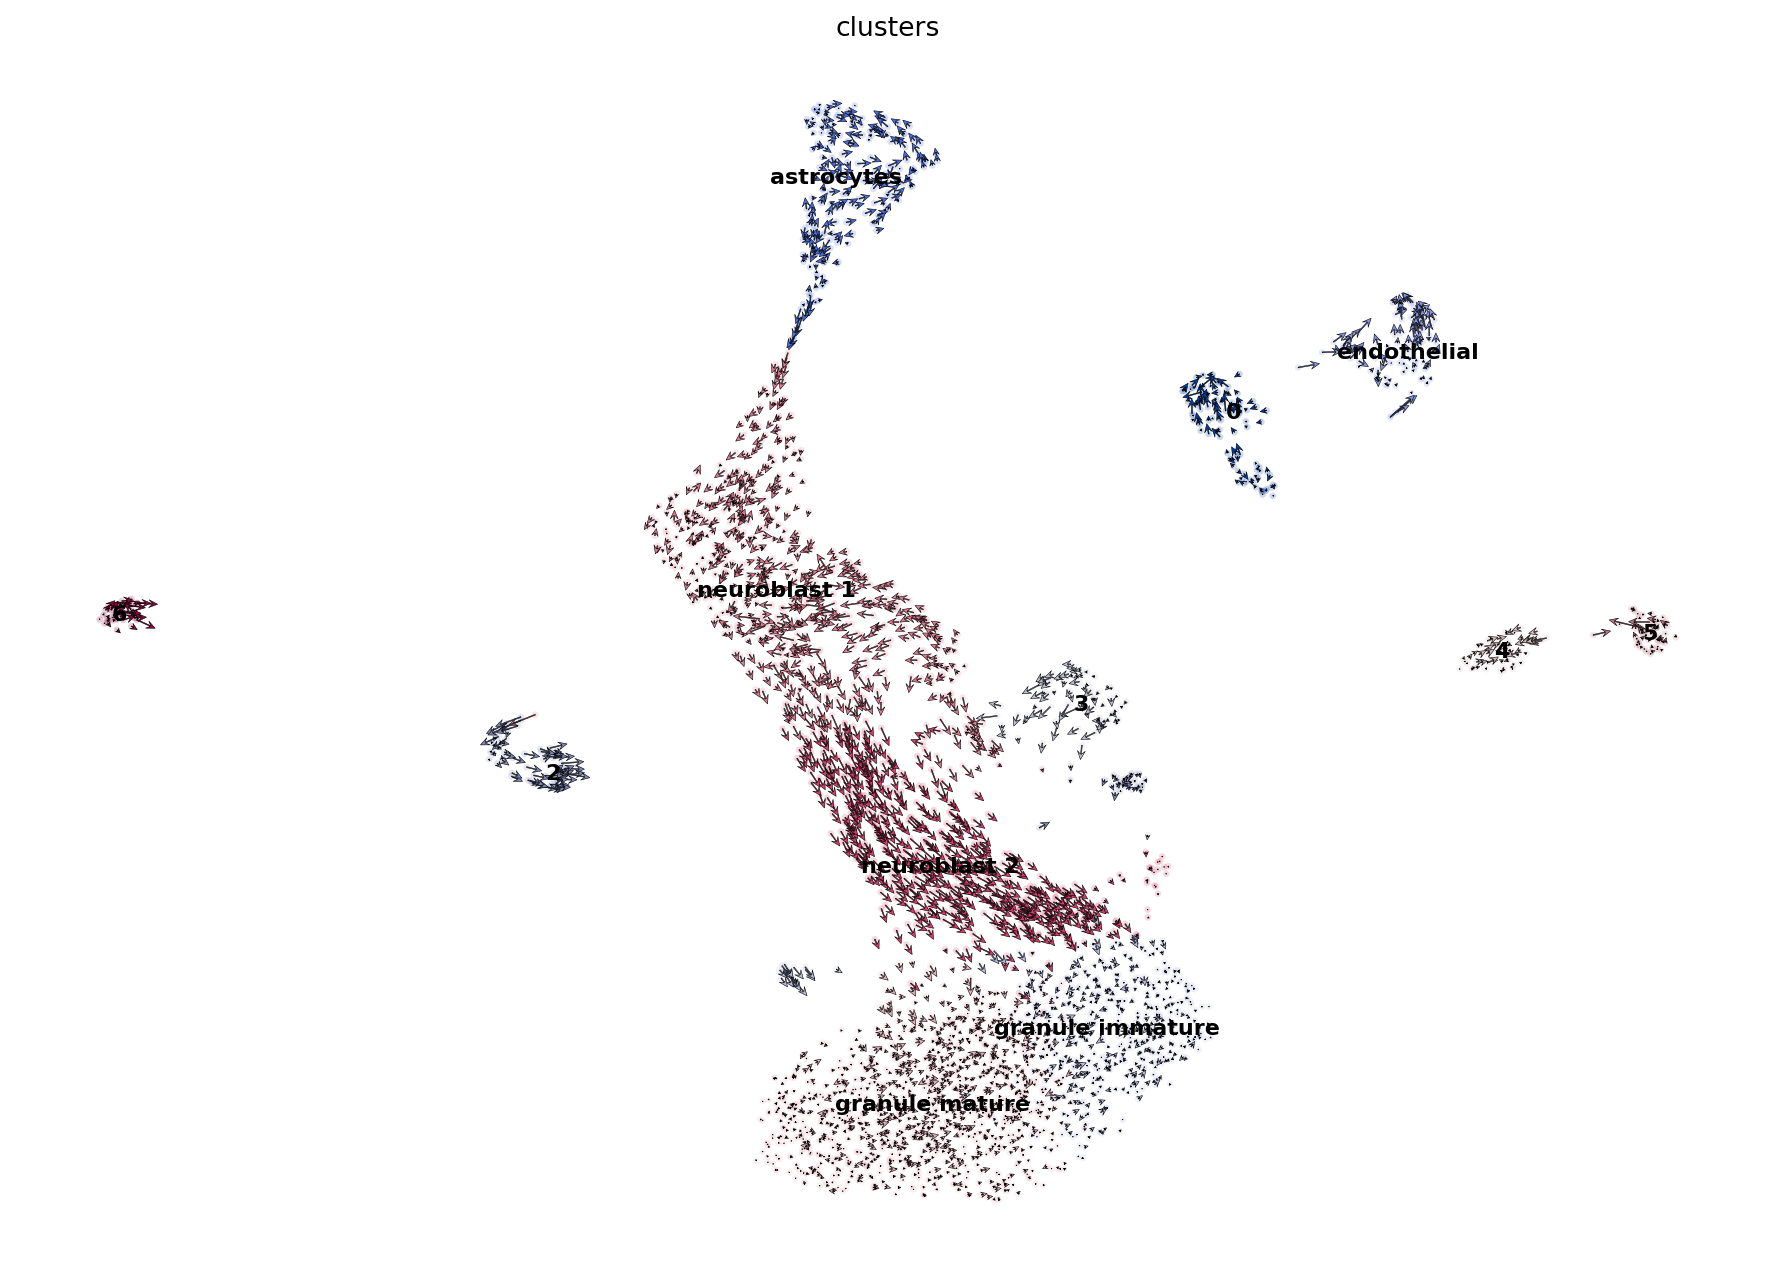

In [12]:
scv.pl.velocity_embedding(adata, basis='umap', color='clusters', scale=2.5, legend_loc='on data')

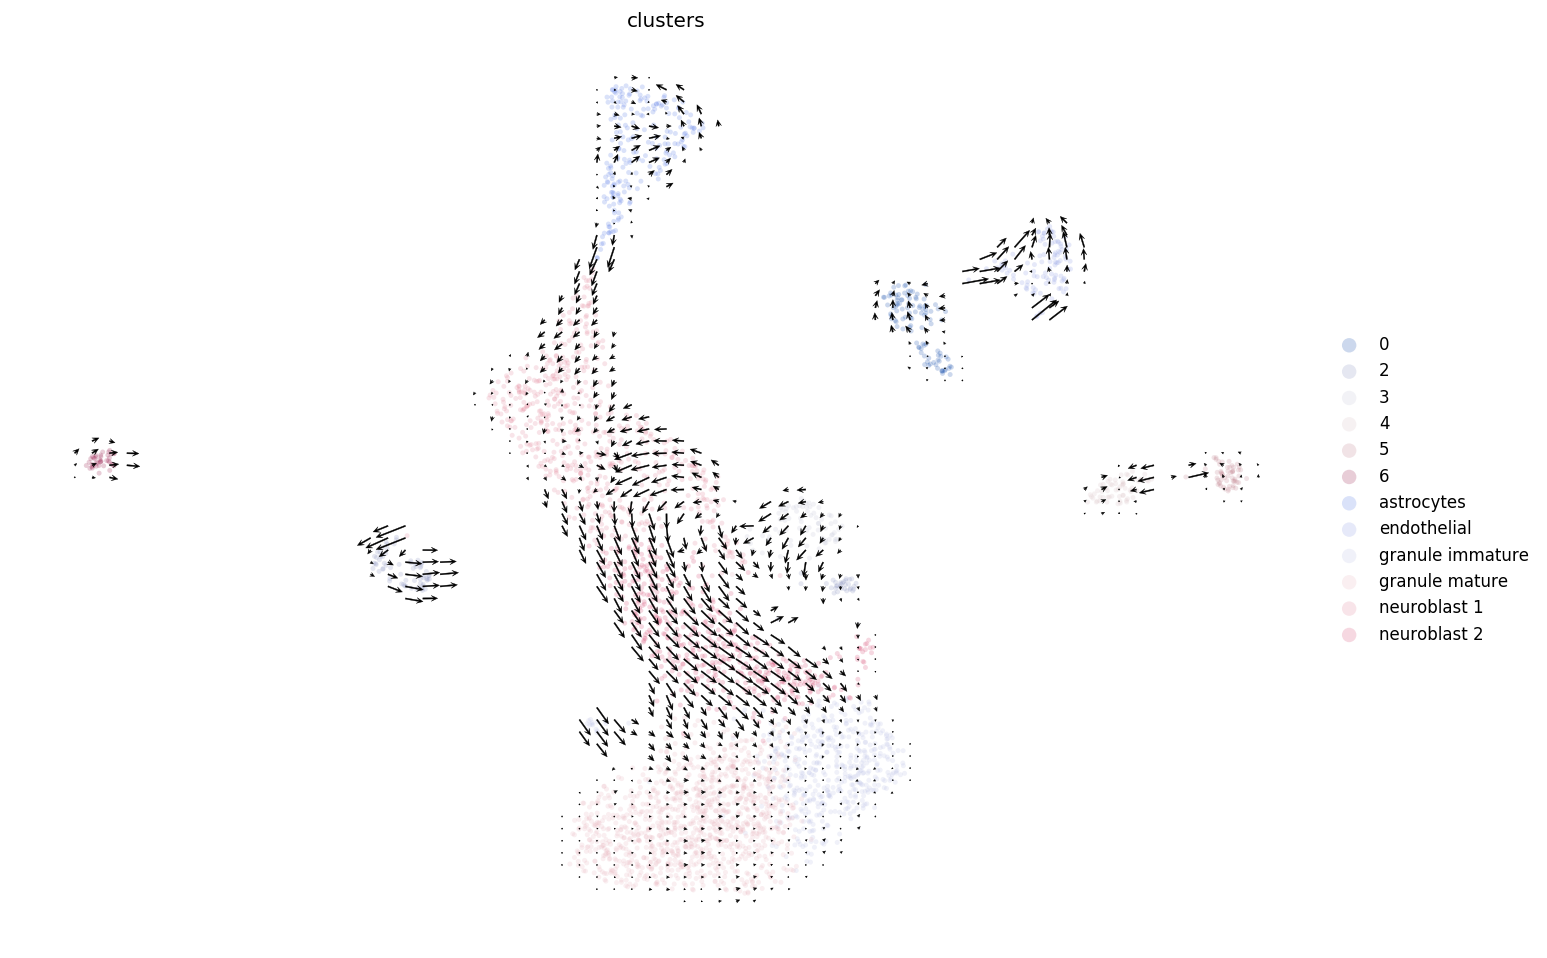

In [13]:
scv.pl.velocity_embedding_grid(adata, basis='umap', color='clusters', density=1.2, scale=1.5)

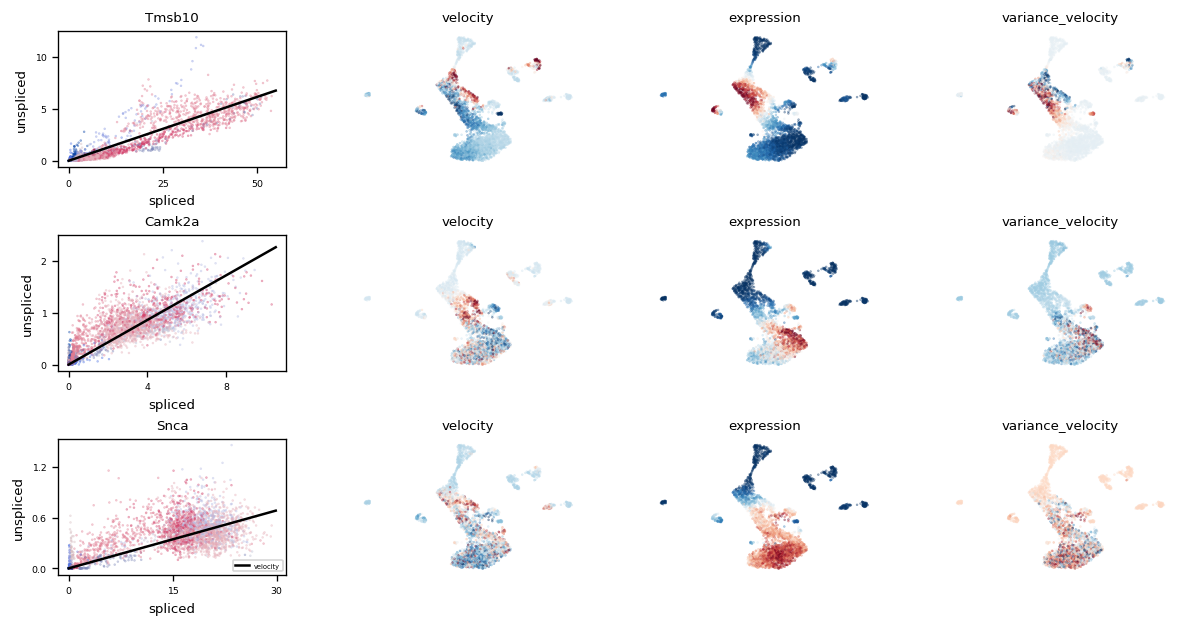

In [14]:
scv.pl.velocity(adata, var_names=['Tmsb10', 'Camk2a', 'Snca'], color='clusters')

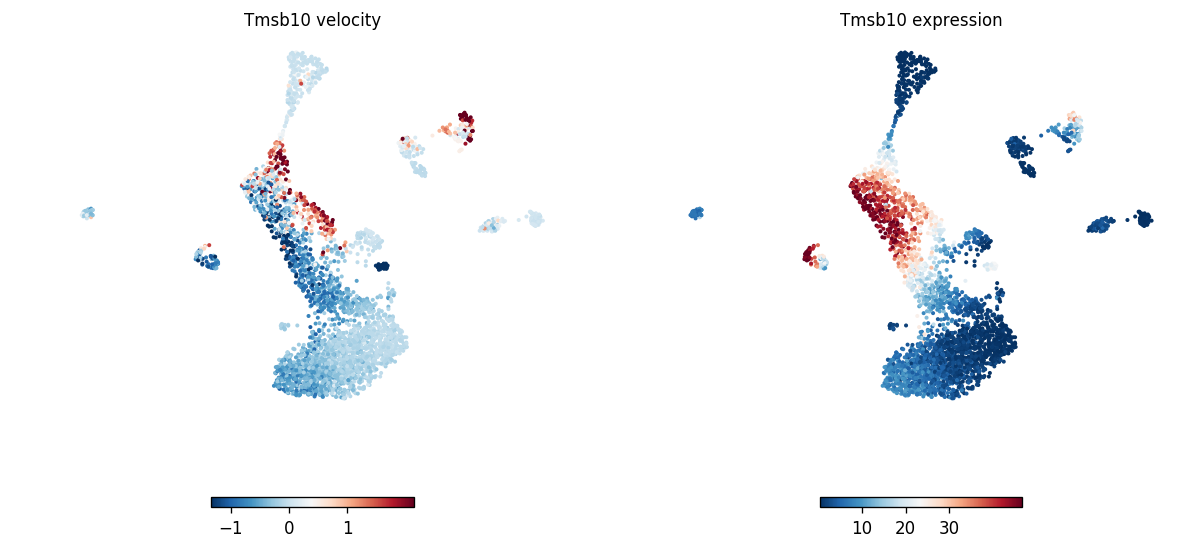

In [15]:
pl.figure(None, (12,6), dpi=120)
gs = pl.GridSpec(1,2)

ax = pl.subplot(gs[0])
#sc.pl.scatter(adata, basis='umap', color='Tmsb10', layers='velocity', color_map='RdBu_r', ax=ax)
scv.pl.scatter(adata, basis='umap', color='Tmsb10', layer='velocity', alpha=1, size=2, color_map='RdBu_r', title='Tmsb10 velocity')
pl.colorbar(orientation='horizontal', shrink=.4, ticks=[-1,0,1])

ax = pl.subplot(gs[1])
scv.pl.scatter(adata, basis='umap', color='Tmsb10', layer='Ms', alpha=1, size=2, color_map='RdBu_r', title='Tmsb10 expression')
pl.colorbar(orientation='horizontal', shrink=.4, ticks=[0,10,20,30])